In [1]:
import sys
import os
os.chdir('./..')
sys.path.append(os.getcwd())

[Preprocessing](#preprocessing):
- [Completion time](#elapsed_time)
- [Language proficiency](#language_proficiency)

[Segue categories](#segue_categories)

[User categories](#user_categories)

[Performance](#performance):
- [Metrics](#metrics)
- [Heatmaps](#heatmaps)

[Interestingness and metrics](#interestingness) </br>
[Text length and likeability](#text_length) </br>
[Confounding effects of familiarity](#familiarity) </br>
<a id="top"></a>

In [2]:
from playlist_explanation.run import save_graph_the_chain
from analyze_answers import segue_eval_df, load_answers, user_traits_df, interestingness_df, segue_text_df, familiarity_df, pull_treatment,segue_category_df, user_category_df
import pandas as pd
from scipy import stats
import re
import seaborn as sns
sns.set_theme()
pd.set_option("max_rows", 20)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logging
logging.getLogger().setLevel(logging.ERROR)

def trunc(number, n_digits):
    return '{:.{prec}f}'.format(number, prec=n_digits)

def to_latex(df):
    d={'likeable': '\\likeable','funny': '\\funny','informative': '\\informative','creative': '\\creative','high_quality': '\\hq', 'sparked_interest': '\\si', 'well_written':'\\ww', 'the_chain':'\\chain', 'dave': '\\dave', 'understandable': '\\understandable'}
    df=df.rename(d, axis=1)
    df=df.rename(d, axis=0)
    
    s="\\begin{table} \n"
    s+=df.to_latex(multicolumn_format='c', column_format=f'l{"c"*df.shape[1]}', escape=False, \
                   header=[c[0] if type(c)==tuple else c for c in df.columns.values] if type(df.columns.values[0])==str else True, \
                   formatters=[lambda x: '$'+re.sub(r'(\*+)', '^{\g<1>}', x)+'$' for _ in range(len(df.columns))])
    s+="\\caption{} \n \\label{} \n \\end{table}"
    
    s=s.replace('\\textbackslash ', '\\')
    print(s)

# Preprocessing
<a id="preprocessing"></a>
[Go to top](#top)

Total number of answers: 158

We discard answers if at least one of the following is verified:
- completion time < 3 min
- language proficiency == mid

In [3]:
print(f"After filtering, we end up with {len(load_answers())} answers")

After filtering, we end up with 151 answers


## Completion time
<a id="elapsed_time"></a>
[Go to top](#top)

In [4]:
elapsed_times = [a['elapsed_time']/60 for a in load_answers()]
print(f"Median completion time: {trunc(np.median(elapsed_times),2)} minutes")
print(f"Max completion time: {trunc(max(elapsed_times),2)} minutes")
print(f"Min completion time: {trunc(min(elapsed_times),2)} minutes")

Median completion time: 7.37 minutes
Max completion time: 68.95 minutes
Min completion time: 3.36 minutes


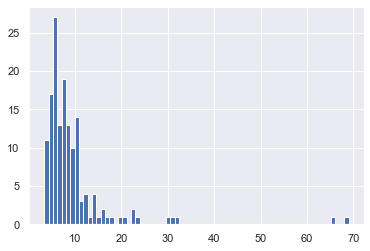

In [5]:
_=plt.hist(elapsed_times, bins=70)

## Language proficiency
<a id="language_proficiency"></a>
[Go to top](#top)

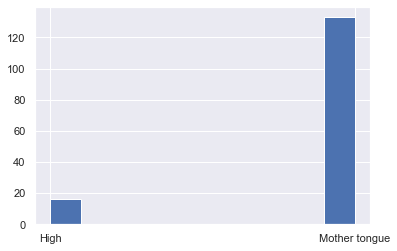

In [6]:
df = user_traits_df(load_answers())
_=df.proficiency.hist()

# Segue categories
<a id="segue_categories"></a>
[Go to top](#top)

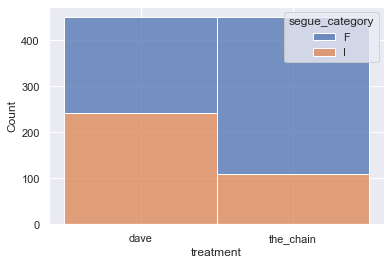

In [7]:
df_eval = segue_eval_df(load_answers())
df_segue_cat = segue_category_df()
df = df_eval.set_index(['segue_idx','treatment']).join(df_segue_cat.set_index(['segue_idx','treatment']), how='left').reset_index()
_=sns.histplot(data=df, x='treatment', hue="segue_category", multiple="stack")

- The two methods are both biased, The Chain towards funny and Dave towards informative

# User categories
<a id="user_categories"></a>
[Go to top](#top)

### Separation strategies

#### Quartiles

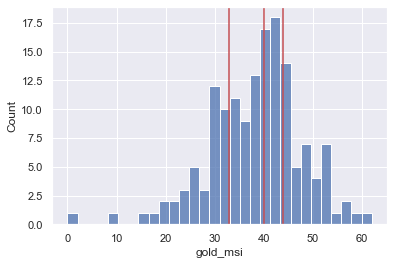

In [8]:
df_traits = user_traits_df(load_answers()).drop("proficiency", axis=1)
df_traits['gold_msi']=df_traits[df_traits.columns[1:]].sum(axis=1)
df_traits=df_traits[df_traits.columns[[0,10]]]
_=sns.histplot(df_traits['gold_msi'], bins=30)
for n in df_traits['gold_msi'].quantile([0.25,0.5,0.75]):
    plt.axvline(n, 0,100, color='r')

Confidence interval in performance -> metric show cohesion on first and fourth quartiles. This is an hint that partitioning with quartiles is good.

**I've picked this strategy**

# Performance
<a id="performance"></a>

## Metrics
<a id="metrics"></a>
[Go to top](#top)

#### Union

In [9]:
def performance_table(df, attribute, test_type='rel', tests=[], include_union=False):
    digits=2
    attribute = attribute if type(attribute) is list else [attribute]
    l=['likeable', 'high_quality','sparked_interest','funny','informative','creative', 'understandable','well_written']
    _df=df[attribute+l]
    add1=_df.groupby(attribute).mean().astype(np.object)
    add2=_df[l].mean().to_frame().T.rename({0:'union'}).astype(np.object)
    
    add1_formatted = add1.copy()
    add2_formatted = add2.copy()
    for v1, v2 in tests:
        for j, c in enumerate(l):

            df_slice_v1=df.copy()
            for a,v in zip(attribute,list(v1) if type(v1) is tuple else [v1]):
                df_slice_v1 = df_slice_v1[df_slice_v1[a]==v]
                
            df_slice_v2=df.copy()
            for a,v in zip(attribute,list(v2) if type(v2) is tuple else [v2]):
                df_slice_v2 = df_slice_v2[df_slice_v2[a]==v]
            
            if test_type=='rel':
                statistics, p = stats.ttest_rel(df_slice_v1[c].values, df_slice_v2[c].values, nan_policy='omit')
            elif test_type=='ind':
                statistics, p = stats.ttest_ind(df_slice_v1[c].values, df_slice_v2[c].values, nan_policy='omit')

            if p < 0.001:
                score_prefix = '***'
            elif p >= 0.001 and p<0.01:
                score_prefix = '**'
            elif p>=0.01 and p<0.05:
                score_prefix = '*'
            else:
                score_prefix = ''
                
            if add1.loc[v1][j]>=add1.loc[v2][j]:
                add1_formatted.loc[v1][j] = f"{trunc(add1.loc[v1][j],digits)}{score_prefix}"
                add1_formatted.loc[v2][j] = trunc(add1.loc[v2][j],digits)
            else:
                add1_formatted.loc[v1][j] = trunc(add1.loc[v1][j],digits)
                add1_formatted.loc[v2][j] = f"{trunc(add1.loc[v2][j],digits)}{score_prefix}"

            add2_formatted.iloc[0][j] = trunc(add2.iloc[0][j],digits)
    
    if include_union:
        return pd.concat([add1_formatted[l], add2_formatted[l]])
    else:
        return add1_formatted[l].set_index(pd.Index(add1_formatted[l].index.values))

In [10]:
df = segue_eval_df(load_answers())
table = performance_table(df,attribute='treatment', tests=[('dave', 'the_chain')])
table

,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,3.11,3.01,2.92,2.54,3.23**,3.28,3.72,3.30
the_chain,3.26*,3.16*,3.02,2.83***,3.03,3.58***,3.76,3.34


*Paired t-test*.</br>
\*: p-value < 0.05 </br>
\*\*: p-value < 0.01 </br>
\*\*\*: p-value < 0.001

**Notice**: here I'm assuming that every user had took book treatments just one time. We can either ignore this, or do some additional tests. We ignore this. </br>

We score high on understandable, users get segues

**We drop this table, here we are mixing funny and informative segues. It is better to compare them separately**

#### Partition by user category

##### Across treatments, no significant difference between treatments

In [11]:
df_eval = segue_eval_df(load_answers())
df_user_cat = user_category_df()
df = df_eval.set_index('user_idx').join(df_user_cat.set_index('user_idx'), how='left').reset_index()

In [12]:
table=performance_table(df,'user_category', tests=[('1','2'),('1','3'),('1','4')], test_type='ind')
table=table.rename(index={'1': 'low AE', '2': 'mid-low AE', '3':'mid-high AE', '4':'high AE',})
table

,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
low AE,3.08,3.00,2.64,2.56,3.07,3.28,3.63,3.18
mid-low AE,3.20,3.08,2.97**,2.72,3.01,3.34,3.71,3.23
mid-high AE,3.19,3.09,3.16***,2.80*,3.26,3.54**,3.72,3.46**
high AE,3.25,3.16,3.09***,2.66,3.19,3.53**,3.86*,3.42*


Testing first row against the all the others

In [13]:
to_latex(table)

\begin{table} 
\begin{tabular}{lcccccccc}
\toprule
{} & \likeable &     \hq &           \si &      \funny & \informative &    \creative & \understandable &          \ww \\
\midrule
low AE      &    $3.08$ &  $3.00$ &        $2.64$ &      $2.56$ &       $3.07$ &       $3.28$ &          $3.63$ &       $3.18$ \\
mid-low AE  &    $3.20$ &  $3.08$ &   $2.97^{**}$ &      $2.72$ &       $3.01$ &       $3.34$ &          $3.71$ &       $3.23$ \\
mid-high AE &    $3.19$ &  $3.09$ &  $3.16^{***}$ &  $2.80^{*}$ &       $3.26$ &  $3.54^{**}$ &          $3.72$ &  $3.46^{**}$ \\
high AE     &    $3.25$ &  $3.16$ &  $3.09^{***}$ &      $2.66$ &       $3.19$ &  $3.53^{**}$ &      $3.86^{*}$ &   $3.42^{*}$ \\
\bottomrule
\end{tabular}
\caption{} 
 \label{} 
 \end{table}


**Story**

- Sparked_interest goes up with gold_msi in a statistical significant way. Maybe, since they are more interested in music, are keen to discover songs. Maybe, the concept of checking out new music is related to some questions in the gold-msi;
- All the other metrics go up with quartiles, but _not_ in a stat significant way;
- Segues are appreciated by nerds as by pop people. But nerds would be more persuaded by segues to listen to music.


This tables does not change if we consider twotiles and threetiles

We obtain a table with the same behaviour as this if we further partition by segue category

#### Partition by segue category

Across treatments

In [14]:
df_eval = segue_eval_df(load_answers())
df_segue_cat = segue_category_df()
df = df_eval.set_index(['segue_idx','treatment']).join(df_segue_cat.set_index(['segue_idx','treatment']), how='left').reset_index()
performance_table(df, attribute='segue_category', test_type='ind', tests=[('F', 'I')],)

,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
F,3.15,3.00,2.90,2.82***,2.81,3.44,3.70,3.26
I,3.24,3.22**,3.08*,2.47,3.64***,3.41,3.79,3.42*


**Use this as a validation the ground truth. Statistical significant difference in funny and informative (p<0.001)**

In [15]:
print("Informative")
table=performance_table(df[df.segue_category == 'I'], attribute='treatment', test_type='ind', tests=[('dave', 'the_chain')])
table

Informative


,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,3.26,3.22,3.06,2.39,3.73**,3.33,3.84,3.46
the_chain,3.20,3.20,3.13,2.64*,3.43,3.59*,3.69,3.33


In [16]:
to_latex(table)

\begin{table} 
\begin{tabular}{lcccccccc}
\toprule
{} & \likeable &     \hq &     \si &      \funny & \informative &   \creative & \understandable &     \ww \\
\midrule
\dave  &    $3.26$ &  $3.22$ &  $3.06$ &      $2.39$ &  $3.73^{**}$ &      $3.33$ &          $3.84$ &  $3.46$ \\
\chain &    $3.20$ &  $3.20$ &  $3.13$ &  $2.64^{*}$ &       $3.43$ &  $3.59^{*}$ &          $3.69$ &  $3.33$ \\
\bottomrule
\end{tabular}
\caption{} 
 \label{} 
 \end{table}


In [17]:
print("Funny")
table=performance_table(df[df.segue_category == 'F'], attribute='treatment',test_type='ind',tests=[('dave', 'the_chain')])
table

Funny


,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
dave,2.94,2.77,2.76,2.71,2.66,3.22,3.58,3.13
the_chain,3.28***,3.14***,2.99*,2.89*,2.90**,3.57***,3.78*,3.35*


In [18]:
to_latex(table)

\begin{table} 
\begin{tabular}{lcccccccc}
\toprule
{} &     \likeable &           \hq &         \si &      \funny & \informative &     \creative & \understandable &         \ww \\
\midrule
\dave  &        $2.94$ &        $2.77$ &      $2.76$ &      $2.71$ &       $2.66$ &        $3.22$ &          $3.58$ &      $3.13$ \\
\chain &  $3.28^{***}$ &  $3.14^{***}$ &  $2.99^{*}$ &  $2.89^{*}$ &  $2.90^{**}$ &  $3.57^{***}$ &      $3.78^{*}$ &  $3.35^{*}$ \\
\bottomrule
\end{tabular}
\caption{} 
 \label{} 
 \end{table}


Comments in Informative: 
    
- Almost equal in all the quality metrics;
- The Chain is more Funny and Creative, while Dave is more Informative;
- Surprisingly, Dave is more well_written;
- Comments above lack (strong or any) statistical significance.
    
Comments in Funny:

- The Chain wins everywhere, largely;
- Not high score in funny overall, maybe because of the medium;
    
General comments:
    
- Dave is much better at informing than amusing;
- Funny and Informative segues from The Chain are liked the same.

#### Partition by segue category and user category

## Heatmaps
<a id="heatmaps"></a>
[Go to top](#top)

#### Union

In [19]:
digits=2
def heatmap_pvalues(df,rows=['likeable', 'high_quality', 'sparked_interest', 'understandable'], headers=['interestingness', 'unpopularity', 'rarity', 'shortness']):
#     x_ticks=['l', 'h-q', 's-i', 'f', 'i', 'c', 'u', 'w-w']
    x_ticks=['$\it{l}$','$\it{h}{-}\it{q}$','$\it{s}{-}\it{i}$','$\it{f}$','$\it{i}$','$\it{c}$','$\it{u}$','$\it{w}{-}{w}$']
    y_ticks=['$\it{likeable}$','$\it{high}{-}\it{quality}$','$\it{sparked}{-}\it{interest}$','$\it{funny}$','$\it{informative}$','$\it{creative}$','$\it{understandable}$','$\it{well}{-}{written}$']
    vals = []
    signs = []
    df_l=[]
    for r in rows:
        val = []
        sign = []
        d={}
        for h in headers:
            if r==h:
                val.append(1)
                sign.append('1')
            else:
                # person r do not accept nans, and require arrays to be all of the same size
                copy=df[[r,h]]
                copy=copy.dropna()
                s, p = stats.spearmanr(copy[r].values, copy[h].values,)
                val.append(s)
                if p<0.001:
                    sign.append(f"{trunc(s,digits)}$^+$")
#                 elif p>=0.001 and p<0.01:
#                     sign.append(f"{trunc(s,digits)}**")
#                 elif p>=0.01 and p<0.05:
#                     sign.append(f"{trunc(s,digits)}*")
                else:
                    sign.append(trunc(s,digits))
        vals.append(val)
        signs.append(sign)
    
    f, ax = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    
    ax=sns.heatmap(np.array(vals), vmin=-1, vmax=1, annot=np.array(signs), cmap='BrBG', fmt='', annot_kws={'size':18}, xticklabels=x_ticks, yticklabels=y_ticks, ax=ax)
    ax.figure.axes[-1].tick_params(labelsize = 19)
    plt.savefig('heatmap',bbox_inches = 'tight')

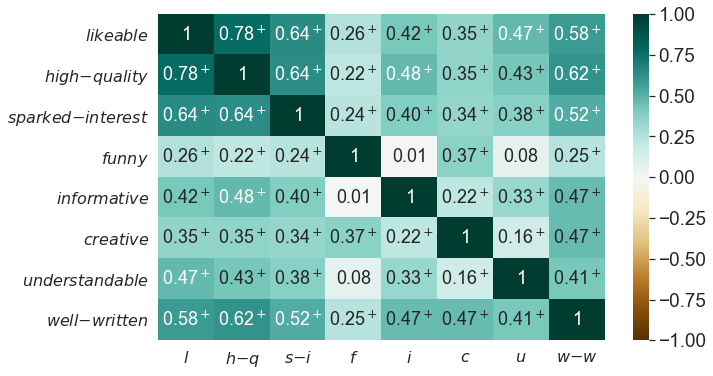

In [20]:
l=['likeable', 'high_quality', 'sparked_interest', 'funny', 'informative', 'creative', 'understandable','well_written']
df=segue_eval_df(load_answers())
heatmap_pvalues(df, rows=l, headers=l)

**Story**

- high_quality and likeable are correlated almost perfectly (.79), maybe perceived as the same question; Showing one after the other maybe was not the best idea ...
- High correlation between high_quality, likeable and sparked_interest, good segues can keep the flow going;
- No correlation (~0) between funny and informative, they are different concepts;
- Informative has higher correlation than funny with all the quality metrics;
- Creative has good correlation with all the quality metrics;
- Understandable is correlated with informative, and probably not correlated with funny.

No significant difference partitioning by treatment, and high uncertainty when partitioning by segue category and user category

# Interestingness and metrics
<a id="interestingness"></a>
[Go to top](#top)

In [21]:
int_df=interestingness_df(load_answers())
eval_df = segue_eval_df(load_answers())
eval_df=eval_df[eval_df.treatment=='dave'].reset_index(drop=True)
segue_cat_df=segue_category_df()
user_cat_df = user_category_df()
segue_cat_df=segue_cat_df[segue_cat_df.treatment=='dave'].drop(['treatment'],axis=1)
df = eval_df.set_index('segue_idx').join(int_df.set_index('segue_idx'), how="left").join(segue_cat_df.set_index('segue_idx'), how='left').reset_index()
df = df.set_index('user_idx').join(user_cat_df.set_index('user_idx'), how='left').reset_index()

In [22]:
digits = 2

def correlation_df_CIs(df,rows=['likeable', 'high_quality', 'sparked_interest', 'understandable'], headers=['interestingness', 'unpopularity', 'rarity', 'shortness']):
    bootstrap_replicas = [df.sample(n=len(df), replace=True) for _ in range(1000)]
    df_l=[]
    for r in rows:
        d={}
        for h in headers:
            d[h]=[br[r].corr(br[h], method='spearman') for br in bootstrap_replicas]
            interval=np.percentile(d[h], 97.5)-np.percentile(d[h], 2.5)
            d[h]=[f"{trunc(np.mean(d[h]),digits)}±{trunc(interval/2,digits)}"]
        df_l.append(pd.DataFrame(d))
    return pd.concat(df_l).rename({j: k for j,k in enumerate(rows)})

def correlation_df_pvalues(df,rows=['likeable', 'high_quality', 'sparked_interest', 'understandable'], headers=['interestingness', 'unpopularity', 'rarity', 'shortness']):
    df_l=[]
    for r in rows:
        d={}
        for h in headers:
            # person r do not accept nans, and require arrays to be all of the same size
            copy=df[[r,h]]
            copy=copy.dropna()
            s, p = stats.spearmanr(copy[r].values, copy[h].values,)
            if p<0.001:
                d[h]=[f"{trunc(s, digits)}***"]
            elif p>=0.001 and p<0.01:
                d[h]=[f"{trunc(s, digits)}**"]
            elif p>=0.01 and p<0.05:
                d[h]=[f"{trunc(s, digits)}*"]
            else:
                d[h]=[trunc(s, digits)]
        df_l.append(pd.DataFrame(d))
    return pd.concat(df_l).reset_index(drop=True).rename({j: k for j,k in enumerate(rows)})

In [23]:
add1 = correlation_df_pvalues(df[df.segue_category=='I'], rows=['interestingness'], headers=['likeable', 'high_quality', 'sparked_interest', 'funny', 'informative', 'creative', 'understandable','well_written'])
add2 = correlation_df_pvalues(df[df.segue_category=='F'], rows=['interestingness'], headers=['likeable', 'high_quality', 'sparked_interest', 'funny', 'informative', 'creative', 'understandable','well_written'])
o = pd.concat([add1, add2])
o=o.set_index(pd.Index(['interestingness','interestingness']))
o=o.set_index(pd.Index(['informative segues','funny segues']), append=True).T
o

interestingness             
                 informative segues funny segues
likeable                    0.25***         0.13
high_quality                0.23***         0.11
sparked_interest             0.17**        -0.00
funny                         -0.06       -0.17*
informative                   0.14*         0.04
creative                      0.15*        -0.09
understandable              0.22***         0.10
well_written                   0.11         0.05

In [24]:
to_latex(o)

\begin{table} 
\begin{tabular}{lcc}
\toprule
{} & \multicolumn{2}{c}{interestingness} \\
{} & informative segues & funny segues \\
\midrule
\likeable       &       $0.25^{***}$ &       $0.13$ \\
\hq             &       $0.23^{***}$ &       $0.11$ \\
\si             &        $0.17^{**}$ &      $-0.00$ \\
\funny          &            $-0.06$ &  $-0.17^{*}$ \\
\informative    &         $0.14^{*}$ &       $0.04$ \\
\creative       &         $0.15^{*}$ &      $-0.09$ \\
\understandable &       $0.22^{***}$ &       $0.10$ \\
\ww             &             $0.11$ &       $0.05$ \\
\bottomrule
\end{tabular}
\caption{} 
 \label{} 
 \end{table}


# Confounding effects of familiarity
<a id="familiarity"></a>
[Go to top](#top)

By the way, unbalanced classes

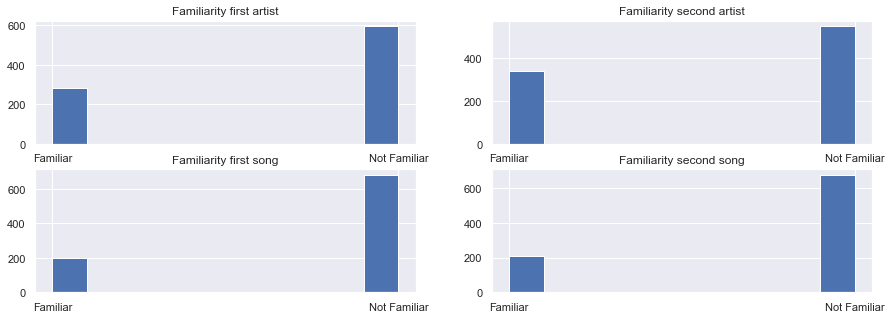

In [25]:
df_familarity=familiarity_df()
fig, (ax1, ax2)=plt.subplots(2,2, figsize=(15,5))
ax1[0].set_title("Familiarity first artist")
ax1[1].set_title("Familiarity second artist")
ax2[0].set_title("Familiarity first song")
ax2[1].set_title("Familiarity second song")
df_familarity.familiarity_first_artist.hist(ax=ax1[0], )
df_familarity.familiarity_second_artist.hist(ax=ax1[1])
df_familarity.familiarity_first_song.hist(ax=ax2[0])
_=df_familarity.familiarity_second_song.hist(ax=ax2[1])

In [26]:
df_eval=segue_eval_df(load_answers())
idx=['segue_idx','user_idx','treatment']
df=df_eval.set_index(idx).join(df_familarity.set_index(idx)).reset_index()

In [27]:
table=performance_table(df, attribute=['familiarity_first_song', 'familiarity_second_song'], test_type='ind', \
                  tests=[(('Not Familiar','Not Familiar'), ('Familiar','Familiar')),\
                        (('Not Familiar','Not Familiar'), ('Familiar','Not Familiar')),\
                        (('Not Familiar','Not Familiar'), ('Not Familiar','Familiar'))])
table=table.reindex([('Not Familiar','Not Familiar'), ('Familiar','Not Familiar'),('Not Familiar','Familiar'),('Familiar','Familiar')])
table=table.rename(index={("Familiar", "Familiar"): "both songs",\
                         ("Familiar", "Not Familiar"): "just $1^{st}$ song",\
                         ("Not Familiar", "Familiar"): "just $2^{nd}$ song",\
                         ("Not Familiar", "Not Familiar"): "neither songs",})
table.index = table.index.rename('familiar with')
table

,likeable,high_quality,sparked_interest,funny,informative,creative,understandable,well_written
familiar with,,,,,,,,
neither songs,3.11,3.03,2.81,2.65,3.08,3.36,3.67,3.25
just $1^{st}$ song,3.22,3.08,3.08*,2.64,3.30*,3.45,3.87,3.40
just $2^{nd}$ song,3.29,3.18,3.27***,2.79,3.16,3.57*,3.86,3.41
both songs,3.49**,3.29*,3.47***,2.78,3.28,3.61*,3.93*,3.61**


Metrics rise, but not in a statistical significant way (maybe too few samples). Here we are testing last row against all the other ones.

- Familiarity with songs makes metrics rise more than familiarity with artists. Other than this, same behaviour, only the magnitude changes. We show just familiarity with songs;
- It does not make sense to partition further (on user category and segue category) because we have already a lot of uncertainty, very few people are familiar with songs and artists.

(Maybe too strong) Takeaways: segues tend to be particularly appreciated when they link songs the user is familiar with. They are not suited for new music discovery, as the sparked_interest metrics tend to be low when the user is familiar with just the first song.
Still, they can be of useful e.g. for decorating playlists of user's old music.

In [28]:
to_latex(table)

\begin{table} 
\begin{tabular}{lcccccccc}
\toprule
{} &    \likeable &         \hq &           \si &  \funny & \informative &   \creative & \understandable &          \ww \\
familiar with      &              &             &               &         &              &             &                 &              \\
\midrule
neither songs      &       $3.11$ &      $3.03$ &        $2.81$ &  $2.65$ &       $3.08$ &      $3.36$ &          $3.67$ &       $3.25$ \\
just $1^{st}$ song &       $3.22$ &      $3.08$ &    $3.08^{*}$ &  $2.64$ &   $3.30^{*}$ &      $3.45$ &          $3.87$ &       $3.40$ \\
just $2^{nd}$ song &       $3.29$ &      $3.18$ &  $3.27^{***}$ &  $2.79$ &       $3.16$ &  $3.57^{*}$ &          $3.86$ &       $3.41$ \\
both songs         &  $3.49^{**}$ &  $3.29^{*}$ &  $3.47^{***}$ &  $2.78$ &       $3.28$ &  $3.61^{*}$ &      $3.93^{*}$ &  $3.61^{**}$ \\
\bottomrule
\end{tabular}
\caption{} 
 \label{} 
 \end{table}
